# **Imports and install of birdnet analyzer**

In [1]:
!pip install --upgrade pip
!pip install librosa resampy birdnetlib lazy_loader
import os
import joblib
import ast
import numpy as np
import pandas as pd
import warnings
import random
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import zipfile
import librosa
import resampy
import birdnetlib
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime
import glob
import matplotlib.pyplot as plt
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Main_Birdclef/scripts')
import tensorflow as tf
from tqdm import tqdm

import birdclef_utils




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 48.2/61.1 MB 15.3 MB/s eta 0:00:01
Resuming download birdnetlib-0.18.0-py3-none-any.whl (48.2 MB/61.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 6.8 MB/s  0:00:01
  Attempting uninstall: watchdog
    Found existing installation: watchdog 6.0.0
    Uninstalling watchdog-6.0.0:
      Successfully uninstalled watchdog-6.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [birdnetlib]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.11.0 requires watchdog<7.0.0,>=6.0.0, but you have watchdog 2.1.9 which i

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


Mounted at /content/drive


# **Retrieve Main Audio and Metadata**

In [10]:
birdclef_utils.retrieve_and_process_birdclef_data(zip_filename='ColabUploads.zip')
birdclef_utils.retrieve_and_process_birdclef_data()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from ColabUploads.zip to /content/data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from birdclef-2025.zip to /content/data


# **Google Bird Vocalization Classifier**
Sets up directory to hold the Google Bird Vocalization Classifier data.  This is used later in the notebook.

In [11]:
# Extract tar.gz file into 'models' folder inside your Drive
!tar -xzvf /content/drive/MyDrive/Main_Birdclef/models/bird-vocalization-classifier-tensorflow2-bird-vocalization-classifier-v8.tar.gz -C /content/drive/MyDrive/Main_Birdclef/models

# Create bird_model dir inside 'models' if it doesn't exist (optional)
!mkdir -p /content/drive/MyDrive/Main_Birdclef/models/bird_model

# Move extracted model files into bird_model folder
!mv /content/drive/MyDrive/Main_Birdclef/models/saved_model.pb /content/drive/MyDrive/Main_Birdclef/models/variables /content/drive/MyDrive/Main_Birdclef/models/assets /content/drive/MyDrive/Main_Birdclef/models/bird_model/



assets/
assets/family.csv
assets/genus.csv
assets/label.csv
assets/order.csv
assets/tflite_ckpt.txt
saved_model.pb
variables/
variables/variables.data-00000-of-00001
variables/variables.index


# **Directories**
- Creates the supplemental_files directory if it doesnt exist
- Creates the CSVs directory if it doesnt exist.  All csvs created in this notebook are sent to `Main_Birdclef/CSVs`.

In [12]:
main_dir='/content/data/'
main_processed_dir=os.path.join(main_dir,'ColabUploads')
processed_dir=os.path.join(main_processed_dir,'KaggleUploads')
drive_dir='/content/drive/MyDrive'
output_dir=os.path.join(drive_dir,'Main_Birdclef','CSVs')

# Create 'Main_Birdclef' and 'CSVs' directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
# Define the supplemental_files directory inside Main_Birdclef
supplemental_files_dir = os.path.join(os.path.join(drive_dir,'Main_Birdclef'), 'supplemental_files')

# Create both Main_Birdclef and supplemental_files directories if they don't exist
os.makedirs(supplemental_files_dir, exist_ok=True)

In [13]:
original_train_filenames=np.load(os.path.join(processed_dir,'train_filenames.npy'))
original_test_filenames=np.load(os.path.join(processed_dir,'test_filenames.npy'))
original_val_filenames=np.load(os.path.join(processed_dir,'val_filenames.npy'))
added_fnames=[f for f in original_test_filenames[:4000]]
original_train_filenames=list(original_train_filenames)+added_fnames

In [15]:
warnings.filterwarnings('ignore')
df = pd.read_csv(os.path.join(processed_dir,'speech_cleaned_audio_with_duration.csv'), dtype={'primary_label': 'object'})
df['secondary_labels'] = df['secondary_labels'].apply(ast.literal_eval)

# Path to the label encoder file
label_encoder_path = os.path.join(supplemental_files_dir,'bird_label_encoder.joblib')

try:
    # Load the label encoder
    label_encoder = joblib.load(label_encoder_path)
    print(f"Successfully loaded label_encoder from: {label_encoder_path}")
except FileNotFoundError:
    print(f"Error: File not found at: {label_encoder_path}. "
          f"Please ensure the dataset 'processing-models' is attached and the path is correct.")
taxonomy=pd.read_csv(os.path.join(main_dir,'taxonomy.csv'))
taxonomy_mapping=taxonomy.set_index('primary_label')['scientific_name'].to_dict()

Successfully loaded label_encoder from: /content/drive/MyDrive/Main_Birdclef/supplemental_files/bird_label_encoder.joblib


# **Birdnet Analyzer Structure**
- Example of what the analyzer will return

In [19]:
my_birds=df['scientific_name'].unique()
idx=99
audio_file = os.path.join(main_dir,'train_soundscapes',os.listdir(os.path.join(main_dir, 'train_soundscapes') )[idx] )
analyzer = Analyzer()
recording = Recording(
    analyzer,
    audio_file,  # Use the same file as above
    min_conf=0.1
)
recording.analyze()
print("Detections:", recording.detections)


Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H06_20230428_130500.ogg
Detections: [{'common_name': 'Ruddy Ground Dove', 'scientific_name': 'Columbina talpacoti', 'start_time': 0.0, 'end_time': 3.0, 'confidence': 0.17491871118545532, 'label': 'Columbina talpacoti_Ruddy Ground Dove'}, {'common_name': 'Barred Owl', 'scientific_name': 'Strix varia', 'start_time': 0.0, 'end_time': 3.0, 'confidence': 0.10612352937459946, 'label': 'Strix varia_Barred Owl'}, {'common_name': 'Crested Lark', 'scientific_name': 'Galerida cristata', 'start_time': 9.0, 'end_time': 12.0, 'confidence': 0.10944579541683197, 'label': 'Galerida cristata_Crested Lark'}, {'common_name': 'Mourning Dove', 'scientific_name': 'Zenaida macroura', 'start_time': 12.0, 'end_time': 15.0, 'confidence': 0.17229661345481873, 'label': 'Zenaida macroura_Mourning Dove'}, {'common_name': 'Ruddy Ground Dov

# **Birdnet Confidences: train_soundscapes**
- Cell one includes predictions for only birdclef classes
- Cell two includes predictions for any bird


In [ ]:
my_birds = set(df['scientific_name'].unique())
label_mapping = df.groupby('scientific_name').first()['primary_label'].to_dict()
results = []

soundscape_dir = os.path.join(main_dir, 'train_soundscapes')
soundscape_files = os.listdir(soundscape_dir)

analyzer = Analyzer()

SAVE_INTERVAL = 500  # Save every 500 files
SAVE_PARTIAL=False
for idx, fname in enumerate(soundscape_files):
    audio_file = os.path.join(soundscape_dir, fname)
    recording = Recording(
        analyzer,
        audio_file,
        min_conf=0.1
    )
    recording.analyze()
    filtered_detections = [d for d in recording.detections if d['scientific_name'] in my_birds]
    for det in filtered_detections:
        results.append({
            'file': fname,
            'start_time': det['start_time'],
            'end_time': det['end_time'],
            'confidence': det['confidence'],
            'scientific_name': det['scientific_name'],
            'primary_label': label_mapping.get(det['scientific_name'], 'unknown')
        })
    # Save progress every SAVE_INTERVAL files
    if (idx + 1) % SAVE_INTERVAL == 0 and SAVE_PARTIAL:
        temp_df = pd.DataFrame(results)
        temp_path = os.path.join(output_dir, f'birdnet_soft_labels_partial_{idx+1}.csv')
        temp_df.to_csv(temp_path, index=False)
        print(f"Saved partial results at file {idx+1} to {temp_path}")

# Final save
results_df = pd.DataFrame(results)
final_path = os.path.join(output_dir, 'birdnet_soft_labels.csv')
results_df.to_csv(final_path, index=False)
print(f"Final results saved to {final_path}")



Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H21_20230423_000000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H69_20230516_022000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H88_20230509_024500.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H19_20230429_002500.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H18_20230518_161500.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H27_20230515_031000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H32_20230501_023000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H12_20230424_195000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H89

KeyboardInterrupt: 

# **Birdnet Soundscape Predictions (Allow any label)**

In [ ]:
my_birds = set(df['scientific_name'].unique())
label_mapping = df.groupby('scientific_name').first()['primary_label'].to_dict()
results = []

soundscape_dir = os.path.join(main_dir, 'train_soundscapes')
soundscape_files = os.listdir(soundscape_dir)

analyzer = Analyzer()

SAVE_INTERVAL = 2000  # Save every 2000 files
SAVE_PARTIAL=False
for idx, fname in enumerate(soundscape_files):
    audio_file = os.path.join(soundscape_dir, fname)
    recording = Recording(
        analyzer,
        audio_file,
        min_conf=0.1
    )
    recording.analyze()
    filtered_detections = [d for d in recording.detections if d['scientific_name'] ]
    for det in filtered_detections:
        results.append({
            'file': fname,
            'start_time': det['start_time'],
            'end_time': det['end_time'],
            'confidence': det['confidence'],
            'scientific_name': det['scientific_name'],
            'primary_label': label_mapping.get(det['scientific_name'], 'unknown')
        })
    # Save progress every SAVE_INTERVAL files
    if (idx + 1) % SAVE_INTERVAL == 0 and SAVE_PARTIAL:
        temp_df = pd.DataFrame(results)
        temp_path = os.path.join(output_dir, f'birdnet_soft_labels_partial_{idx+1}.csv')
        temp_df.to_csv(temp_path, index=False)
        print(f"Saved partial results at file {idx+1} to {temp_path}")

# Final save
results_df = pd.DataFrame(results)
final_path = os.path.join(output_dir, 'birdnet_soft_labels_any_label.csv')
results_df.to_csv(final_path, index=False)
print(f"Final results saved to {final_path}")


Streaming output truncated to the last 5000 lines.
read_audio_data: complete, read  20 chunks.
analyze_recording H22_20230508_125500.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H78_20230504_173500.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H83_20230511_021000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H07_20230501_120000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H88_20230503_091000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H16_20230513_150000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H30_20230512_052000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H03_20230506_110000.ogg
read_audio_data
read_audio_data: complete, read  20 chunks.
analyze_recording H14_20230425_134500.ogg
read_audio_data
read_audio_data: complete, read

# **Birdnet Predictions: Train Audio**
- Retrieve confidences for only the birdclef assigned primary label only.

In [ ]:
results = []
SAVE_INTERVAL = 500  # Save every 500 files
SAVE_PARTIAL=False
MIN_CONFIDENCE = 0.1  # Adjust this threshold as needed

# Initialize analyzer
analyzer = Analyzer()

# Get all audio files recursively
train_audio_dir = os.path.join(main_dir, 'train_audio')
audio_files = []
for root, dirs, files in os.walk(train_audio_dir):
    for file in files:
        if file.lower().endswith(('.wav', '.ogg', '.mp3', '.flac')):
            full_path = os.path.join(root, file)
            # Convert path to DataFrame format (relative path with '/')
            relative_path = os.path.relpath(full_path, train_audio_dir).replace(os.sep, '/')
            audio_files.append(relative_path)

print(f"Found {len(audio_files)} audio files to process")

for idx, relative_path in enumerate(audio_files):
    # Get primary label from DataFrame
    file_df = df[df['filename'] == relative_path]

    if file_df.empty:
        print(f"Skipping {relative_path} - not found in DataFrame")
        continue

    primary_label = file_df.iloc[0]['primary_label']
    scientific_name = file_df.iloc[0]['scientific_name']

    # Full path to audio file
    audio_file = os.path.join(train_audio_dir, relative_path)

    # Analyze with BirdNET
    recording = Recording(
        analyzer,
        audio_file,
        min_conf=MIN_CONFIDENCE
    )
    recording.analyze()

    # Filter detections for this file's primary label
    filtered_detections = [
        d for d in recording.detections
        if d['scientific_name'] == scientific_name
    ]

    # Record results
    for det in filtered_detections:
        results.append({
            'filename': relative_path,
            'start_time': det['start_time'],
            'end_time': det['end_time'],
            'confidence': det['confidence'],
            'scientific_name': scientific_name,
            'primary_label': primary_label
        })

    # Save progress
    if (idx + 1) % SAVE_INTERVAL == 0 and SAVE_PARTIAL:
        temp_df = pd.DataFrame(results)
        temp_path = os.path.join(output_dir, f'birdnet_train_labels_{idx+1}.csv')
        temp_df.to_csv(temp_path, index=False)
        print(f"Saved progress after {idx+1} files")

# Final save
final_df = pd.DataFrame(results)
final_path = os.path.join(output_dir, 'birdnet_train_labels_final.csv')
final_df.to_csv(final_path, index=False)
print(f"Processing complete. Final results saved to {final_path}")



Streaming output truncated to the last 5000 lines.
analyze_recording XC536113.ogg
read_audio_data
read_audio_data: complete, read  4 chunks.
analyze_recording XC257071.ogg
read_audio_data
read_audio_data: complete, read  2 chunks.
analyze_recording XC299104.ogg
read_audio_data
read_audio_data: complete, read  27 chunks.
analyze_recording XC523893.ogg
read_audio_data
read_audio_data: complete, read  5 chunks.
analyze_recording XC128812.ogg
read_audio_data
read_audio_data: complete, read  11 chunks.
analyze_recording XC80918.ogg
read_audio_data
read_audio_data: complete, read  8 chunks.
analyze_recording XC523895.ogg
read_audio_data
read_audio_data: complete, read  18 chunks.
analyze_recording XC685708.ogg
read_audio_data
read_audio_data: complete, read  3 chunks.
analyze_recording XC838838.ogg
read_audio_data
read_audio_data: complete, read  11 chunks.
analyze_recording XC354897.ogg
read_audio_data
read_audio_data: complete, read  2 chunks.
analyze_recording XC80807.ogg
read_audio_data


# **Birdnet Predictions for secondary labels**

- Gets birdnet confidences for assigned secondary labels in train_audio.

In [ ]:
# Load taxonomy and build mapping
taxonomy = pd.read_csv(os.path.join(main_dir, 'taxonomy.csv'))
taxonomy_mapping = taxonomy.set_index('primary_label')['scientific_name'].to_dict()

# DataFrame setup
df['isOneBird'] = df['secondary_labels'].apply(lambda x: True if len(x) == 0 or x[0] == '' else False)
secondary_labels_files = df[~df['isOneBird']]['filename'].tolist()
secondary_labels_mapping = df.set_index('filename')['secondary_labels'].to_dict()

results = []
MIN_CONFIDENCE = 0.1
analyzer = Analyzer()
train_audio_dir = os.path.join(main_dir, 'train_audio')

for relative_path in secondary_labels_files:
    secondary_labels = secondary_labels_mapping[relative_path]
    # Clean up and ensure secondary_labels is a list of non-empty strings
    if isinstance(secondary_labels, str):
        secondary_labels = [label.strip() for label in secondary_labels.split() if label.strip()]
    elif isinstance(secondary_labels, list):
        secondary_labels = [label.strip() for label in secondary_labels if label.strip()]
    else:
        secondary_labels = []
    if not secondary_labels:
        continue

    # Map primary labels to scientific names
    label_to_scientific = {label: taxonomy_mapping[label] for label in secondary_labels if label in taxonomy_mapping}
    if not label_to_scientific:
        continue

    audio_file = os.path.join(train_audio_dir, relative_path)
    if not os.path.isfile(audio_file):
        print(f"File not found: {audio_file}")
        continue

    recording = Recording(analyzer, audio_file, min_conf=MIN_CONFIDENCE)
    recording.analyze()

    for det in recording.detections:
        # For each detection, check if it matches any secondary label scientific name
        for primary_label, scientific_name in label_to_scientific.items():
            if det['scientific_name'] == scientific_name:
                results.append({
                    'filename': relative_path,
                    'start_time': det['start_time'],
                    'end_time': det['end_time'],
                    'confidence': det['confidence'],
                    'scientific_name': det['scientific_name'],
                    'primary_label': primary_label
                })

# Save results to DataFrame
secondary_df = pd.DataFrame(results)
secondary_df.to_csv(os.path.join(output_dir, 'birdnet_secondary_label_detections.csv'), index=False)
print("Done! Saved secondary label detections.")



Streaming output truncated to the last 5000 lines.
analyze_recording XC84887.ogg
read_audio_data
read_audio_data: complete, read  86 chunks.
analyze_recording XC864686.ogg
read_audio_data
read_audio_data: complete, read  23 chunks.
analyze_recording XC900033.ogg
read_audio_data
read_audio_data: complete, read  5 chunks.
analyze_recording XC118874.ogg
read_audio_data
read_audio_data: complete, read  13 chunks.
analyze_recording XC228757.ogg
read_audio_data
read_audio_data: complete, read  13 chunks.
analyze_recording XC228815.ogg
read_audio_data
read_audio_data: complete, read  4 chunks.
analyze_recording XC422214.ogg
read_audio_data
read_audio_data: complete, read  4 chunks.
analyze_recording XC556482.ogg
read_audio_data
read_audio_data: complete, read  4 chunks.
analyze_recording XC556483.ogg
read_audio_data
read_audio_data: complete, read  2 chunks.
analyze_recording XC806662.ogg
read_audio_data
read_audio_data: complete, read  9 chunks.
analyze_recording XC811622.ogg
read_audio_data

In [ ]:
secondary_df.sample(20)

,filename,start_time,end_time,confidence,scientific_name,primary_label
3079,tropar/XC242053.ogg,51.0,54.0,0.539888,Manacus manacus,whbman1
3713,yecspi2/XC709815.ogg,3.0,6.0,0.803811,Donacobius atricapilla,bkcdon
1608,laufal1/XC471141.ogg,123.0,126.0,0.588139,Nyctidromus albicollis,compau
1894,purgal2/XC700097.ogg,3.0,6.0,0.332839,Ardea alba,greegr
1748,paltan1/XC319948.ogg,39.0,42.0,0.155087,Brotogeris jugularis,orcpar
826,cocher1/XC807349.ogg,9.0,12.0,0.253753,Ardea alba,greegr
1349,greibi1/XC705021.ogg,96.0,99.0,0.788058,Legatus leucophaius,pirfly1
2165,rufmot1/XC364004.ogg,108.0,111.0,0.815237,Ramphastos ambiguus,bkmtou1
3965,yercac1/XC245490.ogg,1158.0,1161.0,0.968091,Legatus leucophaius,pirfly1
464,bobfly1/XC297888.ogg,84.0,87.0,0.120574,Galbula ruficauda,rutjac1


# **Birdnet Predictions for all Birdclef classes: Train_Audio**

This will store predictions for all birdclef labels regardless if they are assigned as a primary or secondary label.

In [ ]:
# --- CONFIGURATION ---
SAVE_INTERVAL = 500      # Save every 500 files
SAVE_PARTIAL=False
MIN_CONFIDENCE = 0.1     # Detection threshold
results = []

# Initialize analyzer
analyzer = Analyzer()

       # Slide window by 2 seconds each time)

# Get all audio files recursively
train_audio_dir = os.path.join(main_dir, 'train_audio')
audio_files = []
for root, dirs, files in os.walk(train_audio_dir):
    for file in files:
        if file.lower().endswith(('.wav', '.ogg', '.mp3', '.flac')):
            full_path = os.path.join(root, file)
            relative_path = os.path.relpath(full_path, train_audio_dir).replace(os.sep, '/')
            audio_files.append(relative_path)

print(f"Found {len(audio_files)} audio files to process")

for idx, relative_path in enumerate(audio_files):
    # Get primary label from DataFrame
    file_df = df[df['filename'] == relative_path]
    if file_df.empty:
        print(f"Skipping {relative_path} - not found in DataFrame")
        continue

    # These are the file's nominal labels
    file_primary_label = file_df.iloc[0]['primary_label']
    file_scientific_name = file_df.iloc[0]['scientific_name']

    # Map file's primary_label to scientific_name using taxonomy_mapping
    # Fallback to file_scientific_name if mapping not found
    file_nominal_scientific = taxonomy_mapping.get(file_primary_label, file_scientific_name)

    audio_file = os.path.join(train_audio_dir, relative_path)

    # Analyze with BirdNET
    recording = Recording(analyzer, audio_file, min_conf=MIN_CONFIDENCE)
    recording.analyze()

    # Get all confident detections
    filtered_detections = [d for d in recording.detections if d['confidence'] > MIN_CONFIDENCE]

    for det in filtered_detections:
        results.append({
            'filename': relative_path,
            'start_time': det['start_time'],
            'end_time': det['end_time'],
            'confidence': det['confidence'],
            'primary_label': det['scientific_name'],  # Detected bird
            'is_secondary': det['scientific_name'] != file_nominal_scientific
        })

    # Save progress every SAVE_INTERVAL files
    if (idx + 1) % SAVE_INTERVAL == 0 and SAVE_PARTIAL:
        temp_df = pd.DataFrame(results)
        temp_path = os.path.join(output_dir, f'birdnet_train_labels_{idx+1}_2ND_RUN.csv')
        temp_df.to_csv(temp_path, index=False)
        print(f"Saved progress after {idx+1} files")

# Final save
final_df = pd.DataFrame(results)
final_path = os.path.join(output_dir, 'birdnet_train_labels_2ND_RUN_final.csv')
final_df.to_csv(final_path, index=False)
print(f"Processing complete. Final results saved to {final_path}")


Streaming output truncated to the last 5000 lines.
read_audio_data: complete, read  25 chunks.
analyze_recording XC247304.ogg
read_audio_data
read_audio_data: complete, read  12 chunks.
analyze_recording XC940690.ogg
read_audio_data
read_audio_data: complete, read  3 chunks.
analyze_recording iNat196108.ogg
read_audio_data
read_audio_data: complete, read  23 chunks.
analyze_recording XC169960.ogg
read_audio_data
read_audio_data: complete, read  4 chunks.
analyze_recording XC549939.ogg
read_audio_data
read_audio_data: complete, read  22 chunks.
analyze_recording XC205278.ogg
read_audio_data
read_audio_data: complete, read  7 chunks.
analyze_recording XC344574.ogg
read_audio_data
read_audio_data: complete, read  25 chunks.
analyze_recording iNat324153.ogg
read_audio_data
read_audio_data: complete, read  5 chunks.
analyze_recording XC206682.ogg
read_audio_data
read_audio_data: complete, read  5 chunks.
analyze_recording XC82254.ogg
read_audio_data
read_audio_data: complete, read  33 chunk

# **Google Bird Vocalization Classifier Predictions**
- Collects confidences for the assigned primary and secondary labels from the GBVC.

In [18]:
# Utility: preprocess audio chunks to raw waveform input (160,000 samples)
def preprocess_audio_raw(audio, sr=SR, target_length=160_000):
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
    elif len(audio) > target_length:
        audio = audio[:target_length]
    peak = np.abs(audio).max()
    if peak > 0:
        audio = audio / peak
    return audio.astype(np.float32)
def save_results(results_list, filename):
    df_res = pd.DataFrame(results_list)
    df_res.to_csv(filename, index=False)
    print(f"Saved results to {filename}")

# --- CONFIGURATION ---
MIN_CONFIDENCE = 0.1      # Detection threshold
WINDOW_SECONDS = 5
HOP_SECONDS = 2           # Slide window every 2 seconds
SR = 32000                # Sample rate expected by model
BATCH_SIZE = 16           # Number of windows per batch inference
SAVE_INTERVAL = 500       # Save intermediate every 500 files processed
OUTPUT_DIR = '/content/drive/MyDrive/Main_Birdclef/models/bird_model/bird_vocalization_results'
SAVE_PARTIAL=False

model_dir = '/content/drive/MyDrive/Main_Birdclef/models/bird_model'


audio_dir = os.path.join(main_dir, 'train_audio')
taxonomy_path = os.path.join(main_dir, 'taxonomy.csv')
label_csv_path = os.path.join(model_dir, 'assets', 'label.csv')

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load taxonomy lookup: map primary_label codes to scientific names (can be unused here, but kept for reference)
taxonomy = pd.read_csv(taxonomy_path)
taxonomy_mapping = taxonomy.set_index('primary_label')['scientific_name'].to_dict()

# Load model
model = tf.saved_model.load(model_dir)
infer = model.signatures['serving_default']

# Load class names and assign to model.class_names
label_df = pd.read_csv(label_csv_path)
model.class_names = label_df['ebird2021'].tolist()  # Species codes as used by model



results = []
batch_waveforms = []
batch_metadata = []



try:
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing files"):
        relative_path = row['filename']
        audio_path = os.path.join(audio_dir, relative_path)
        if not os.path.isfile(audio_path):
            print(f"Missing file: {audio_path}")
            continue

        try:
            audio, sr = librosa.load(audio_path, sr=SR)
        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            continue

        duration = librosa.get_duration(y=audio, sr=sr)
        starts = np.arange(0, max(0.01, duration - WINDOW_SECONDS + 0.01), HOP_SECONDS)

        for start_time in starts:
            end_time = min(start_time + WINDOW_SECONDS, duration)
            chunk = audio[int(start_time * sr):int(end_time * sr)]
            waveform = preprocess_audio_raw(chunk, sr=sr)
            batch_waveforms.append(waveform)
            batch_metadata.append((relative_path, start_time, end_time, row))

            # Run inference when batch is full
            if len(batch_waveforms) >= BATCH_SIZE:
                input_tensor = tf.constant(np.stack(batch_waveforms))  # (BATCH_SIZE, 160000)
                outputs = infer(inputs=input_tensor)
                logits = outputs['label']
                probs_batch = tf.sigmoid(logits).numpy()

                for b_idx, probs in enumerate(probs_batch):
                    rel_path, st, et, file_row = batch_metadata[b_idx]
                    primary_label = file_row['primary_label']

                    secondary_list = file_row.get('secondary_labels', [])
                    if isinstance(secondary_list, str):
                        try:
                            secondary_list = ast.literal_eval(secondary_list)
                        except:
                            secondary_list = []
                    if not isinstance(secondary_list, (list, tuple)):
                        secondary_list = []

                    for class_idx, prob in enumerate(probs):
                        if prob > MIN_CONFIDENCE:
                            predicted_code = model.class_names[class_idx]
                            # Only save if predicted species is primary or in secondary labels
                            if predicted_code == primary_label or predicted_code in secondary_list:
                                results.append({
                                    'filename': rel_path,
                                    'start_time': st,
                                    'end_time': et,
                                    'confidence': float(prob),
                                    'primary_label': predicted_code,
                                    'is_secondary': (predicted_code in secondary_list)
                                })

                batch_waveforms.clear()
                batch_metadata.clear()

        # Save intermediate results periodically
        if (idx + 1) % SAVE_INTERVAL == 0 and SAVE_PARTIAL:
            interim_file = os.path.join(OUTPUT_DIR, f'bird_vocalization_results_interim_{idx+1}.csv')
            save_results(results, interim_file)
            results.clear()

    # Process any remaining audio chunks in batch_waveforms
    if batch_waveforms:
        input_tensor = tf.constant(np.stack(batch_waveforms))
        outputs = infer(inputs=input_tensor)
        logits = outputs['label']
        probs_batch = tf.sigmoid(logits).numpy()

        for b_idx, probs in enumerate(probs_batch):
            rel_path, st, et, file_row = batch_metadata[b_idx]
            primary_label = file_row['primary_label']

            secondary_list = file_row.get('secondary_labels', [])
            if isinstance(secondary_list, str):
                try:
                    secondary_list = ast.literal_eval(secondary_list)
                except:
                    secondary_list = []
            if not isinstance(secondary_list, (list, tuple)):
                secondary_list = []

            for class_idx, prob in enumerate(probs):
                if prob > MIN_CONFIDENCE:
                    predicted_code = model.class_names[class_idx]
                    if predicted_code == primary_label or predicted_code in secondary_list:
                        results.append({
                            'filename': rel_path,
                            'start_time': st,
                            'end_time': et,
                            'confidence': float(prob),
                            'primary_label': predicted_code,
                            'is_secondary': (predicted_code in secondary_list)
                        })

        batch_waveforms.clear()
        batch_metadata.clear()

except Exception as e:
    print(f"Unexpected error during processing: {e}")

# Final save
final_file = os.path.join(output_dir, 'gbvc_train_audio.csv')
save_results(results, final_file)
print("All processing done.")




Processing files:   0%|          | 5/28560 [01:05<103:43:42, 13.08s/it]


KeyboardInterrupt: 

## **Update Pseudo-labeled Data using Google Bird Vocalization Classifier**

During evaluation, we found that BirdNET did not confidently predict the assigned primary label for a large number of files. To address this gap, we incorporated predictions from the Google Bird Vocalization Classifier (GBVC).

By leveraging GBVC’s detections, we were able to enrich the pseudo-labeled dataset with additional confident predictions for species that BirdNET missed, improving overall coverage of the assigned species across our audio files.


In [22]:
scientific_name_mapping=df.set_index('scientific_name')['primary_label'].to_dict()
extra_files=np.load(os.path.join(supplemental_files_dir,'unused_filenames.npy'),allow_pickle=True) # Provided
check=pd.read_csv(os.path.join(output_dir, 'birdnet_train_labels_2ND_RUN_final.csv'))
check['scientific_name']=check['primary_label']
check['primary_label']=check['primary_label'].map(scientific_name_mapping)
scientific_name_mapping=df.set_index('scientific_name')['primary_label'].to_dict()
extra_files_df=check[check['filename'].isin(extra_files)]

extra_files_df


,filename,start_time,end_time,confidence,primary_label,is_secondary,scientific_name
0,yercac1/XC236449.ogg,3.0,6.0,0.471953,NaN,True,Pheugopedius rutilus
1,yercac1/XC236449.ogg,9.0,12.0,0.551281,NaN,True,Pheugopedius rutilus
2,yercac1/XC236449.ogg,12.0,15.0,0.138904,blbwre1,True,Pheugopedius fasciatoventris
3,yercac1/XC236449.ogg,15.0,18.0,0.241363,NaN,True,Pheugopedius rutilus
4,yercac1/XC236449.ogg,15.0,18.0,0.130018,blbwre1,True,Pheugopedius fasciatoventris
...,...,...,...,...,...,...,...
362801,cocher1/XC824588.ogg,6.0,9.0,0.520702,NaN,True,Phleocryptes melanops
362802,cocher1/XC450831.ogg,9.0,12.0,0.146989,NaN,True,Alopochen aegyptiaca
362803,cocher1/XC450831.ogg,9.0,12.0,0.126262,NaN,True,Corvus corax
362804,cocher1/XC450831.ogg,12.0,15.0,0.143288,NaN,True,Trogon elegans


## **Plots**

Plots are utilized to assess whether the samples for which BirdNET failed to predict the assigned primary label correspond to challenging (hard) cases or are potentially mislabeled within the BirdCLEF dataset.


Audio with no BirdNet prediction for primary bird: blhpar1/XC518101.ogg


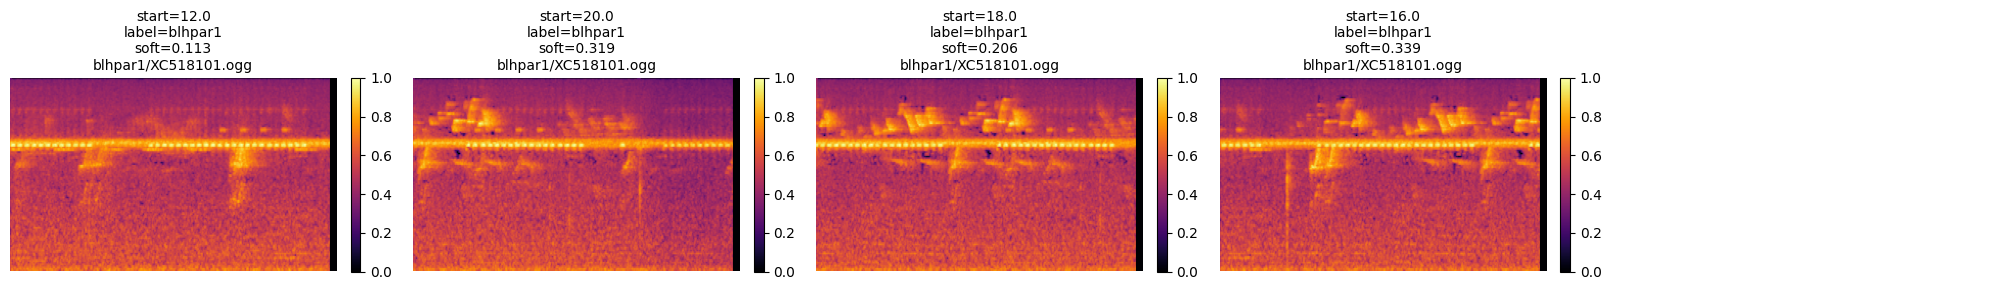

Audio associated with these birds with BirdNet predictions:


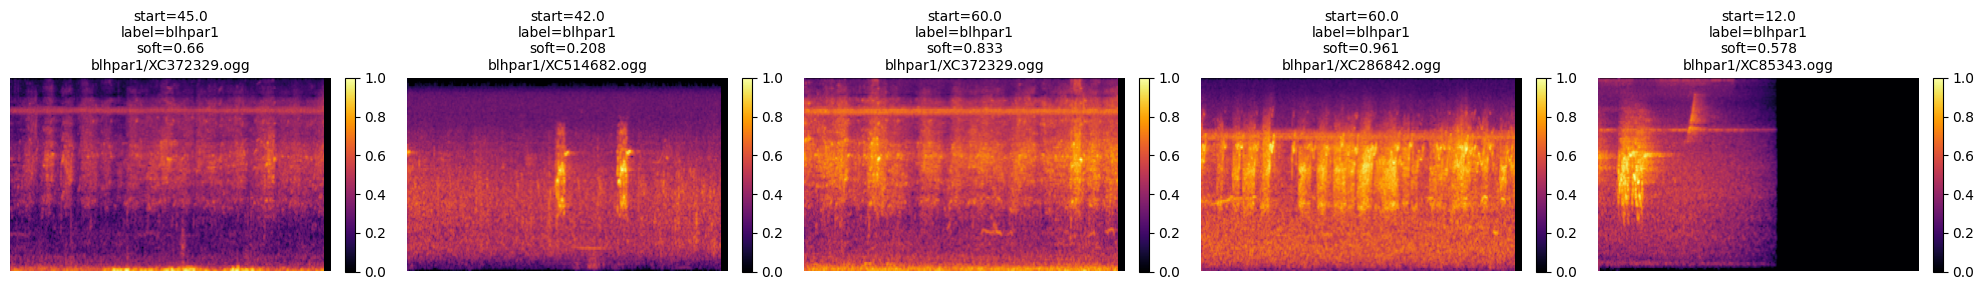

In [68]:
def plot_spectrograms_grid(spectrograms, fnames, start_times, label_names, label_values, ncols=5):
    """
    Plot spectrograms in a grid of subplots with informative titles.
    """
    n = len(spectrograms)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))

    for idx, (spec, fname, stime, label, soft) in enumerate(zip(spectrograms, fnames, start_times, label_names, label_values)):
        ax = axes.flat[idx]
        # Plot only one channel (they are identical for color in EfficientNet)
        im = ax.imshow(spec[:, :, 0].T, origin='lower', aspect='auto', cmap='inferno')
        # Set the title containing all desired info
        title = (
            f"start={stime}\n"
            f"label={label}\n"
            f"soft={np.round(soft, 3)}\n"
            f"{fname}"
        )
        ax.set_title(title, fontsize=10)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Hide unused axes if less than nrows * ncols
    for idx in range(n, nrows * ncols):
        axes.flat[idx].axis('off')

    plt.tight_layout()
    plt.show()
def pad_or_truncate(mel_spec, target_length):
    if mel_spec.shape[0] > target_length:
        return mel_spec[:target_length, :]
    elif mel_spec.shape[0] < target_length:
        pad_width = target_length - mel_spec.shape[0]
        return np.pad(mel_spec, ((0, pad_width), (0, 0)), mode='constant')
    else:
        return mel_spec
def _normalize(audio):
        """Normalizes the audio waveform to the range [-1, 1] based on its peak."""
        peak = np.abs(audio).max()
        if peak > 0:
            return audio / peak
        return audio

def extract_spectrograms(file_list, start_times, sr=32000, segment_duration=5.0, target_time_length_spectrogram=320,normalize=True,audio_dir='train_soundscapes'):
    """
    Extract mel spectrograms from audio files starting at given times,
    each segment exactly segment_duration seconds long (padded if shorter).

    Args:
      file_list (list of str): Paths to audio files.
      start_times (list of float): Start times (seconds) for each file segment.
      sr (int): Sampling rate for librosa.load.
      segment_duration (float): Duration (in seconds) of segment to extract.
      target_time_length_spectrogram (int): Number of mel-spectrogram frames to pad/truncate to.

    Returns:
      list of np.ndarray: List of 3-channel mel spectrogram arrays.
    """
    spectrograms = []
    for file_path, start_time in zip(file_list, start_times):
        f_path=os.path.join(main_dir,audio_dir,file_path)
        # Load the segment from file (exact segment_duration seconds, or shorter if not enough length)
        try:
          audio, _ = librosa.load(f_path, sr=sr, mono=True, offset=start_time, duration=segment_duration)
        except:
          continue
        if normalize:
          audio=_normalize(audio)
        # Extract mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T

        # Normalize to [0, 1]
        min_db, max_db = -80.0, 0.0
        mel_spec_scaled = np.clip((mel_spec_db - min_db) / (max_db - min_db), 0.0, 1.0)

        # Pad or truncate frames to fixed target length
        mel_spec_padded = pad_or_truncate(mel_spec_scaled, target_time_length_spectrogram)[:, :, np.newaxis]

        # Duplicate single channel to 3 channels for EfficientNet input
        mel_spec_padded_3_channel = np.repeat(mel_spec_padded, 3, axis=-1)

        spectrograms.append(mel_spec_padded_3_channel)
    return spectrograms
# Load main bird vocalization data
google_data = pd.read_csv(os.path.join(output_dir, 'gbvc_train_audio.csv'))

# Filter data to only those files with no BirdNet prediction (extra_files)
extra_files_data = google_data[google_data['filename'].isin(extra_files)]
extra_filenames = extra_files_data['filename'].unique()

# Pick a random file from files with no prediction
random_fname = random.choice(extra_filenames)
print(f"Audio with no BirdNet prediction for primary bird: {random_fname}")

# Sample up to 5 chunks from the chosen file with no prediction
no_pred_samples = extra_files_data[extra_files_data['filename'] == random_fname]
no_pred_sample_count = len(no_pred_samples)
no_pred_sampled = no_pred_samples.sample(min(5, no_pred_sample_count))

# Extract arrays for spectrogram extraction and plotting
fnames_no_pred = no_pred_sampled['filename'].values
start_times_no_pred = no_pred_sampled['start_time'].values
labels_no_pred = no_pred_sampled['primary_label'].values
soft_labels_no_pred = no_pred_sampled['confidence'].values

# Extract and plot spectrograms for files with no prediction
specs_no_pred = extract_spectrograms(fnames_no_pred, start_times_no_pred, audio_dir='train_audio')
plot_spectrograms_grid(specs_no_pred, fnames_no_pred, start_times_no_pred, labels_no_pred, soft_labels_no_pred, ncols=5)


# ---- Now handle files with BirdNet predictions for same birds ---- #
# Load BirdNet train labels
birdnet_data = pd.read_csv(os.path.join(output_dir, 'birdnet_train_labels_final.csv'))

# Get unique primary bird labels from no prediction samples
birds_no_pred = list(set(labels_no_pred))

print('Audio associated with these birds with BirdNet predictions:')

for bird_label in birds_no_pred:
    # Filter BirdNet data for this bird label
    bird_samples = birdnet_data[birdnet_data['primary_label'] == bird_label]

    # Sample 5 chunks
    bird_samples_sampled = bird_samples.sample(min(5, len(bird_samples)))

    # Extract arrays for plotting
    fnames_bird = bird_samples_sampled['filename'].values
    start_times_bird = bird_samples_sampled['start_time'].values
    labels_bird = bird_samples_sampled['primary_label'].values
    soft_labels_bird = bird_samples_sampled['confidence'].values

    # Extract and plot spectrograms for BirdNet predictions matching that bird
    specs_bird = extract_spectrograms(fnames_bird, start_times_bird, audio_dir='train_audio')
    plot_spectrograms_grid(specs_bird, fnames_bird, start_times_bird, labels_bird, soft_labels_bird, ncols=5)





It is difficult to conclusively determine whether these samples are mislabeled or simply represent challenging cases. Many appear to be legitimate recordings but may contain vocalizations from multiple species, complicating BirdNET’s ability to accurately predict the assigned primary label. Consequently, I have decided to include these samples in both the training and validation datasets to ensure the model is exposed to this variability.

In [59]:
scientific_name_mapping=df.set_index('scientific_name')['primary_label'].to_dict()
extra_files=np.load(os.path.join(supplemental_files_dir,'unused_filenames.npy'),allow_pickle=True)
google_data=pd.read_csv(os.path.join(output_dir,'gbvc_train_audio.csv'))
extra_files_df=google_data[google_data['filename'].isin(extra_files)]
extra_files_df['scientific_name']=None
secondary_labels_map=df.set_index('filename')['secondary_labels'].to_dict()

gbvc_thresholds=np.load(os.path.join(supplemental_files_dir,'google_start_times_thresholds.npy'),allow_pickle=True).item() # Provided
birdnet_thresholds=np.load(os.path.join(supplemental_files_dir,'birdnet_confidence_thresholds.npy'),allow_pickle=True).item() # Provided

rows_to_keep=[]
for ind, row in extra_files_df.iterrows():
  secondary_labels=secondary_labels_map[row['filename']]
  if row['filename'].split('/')[0]==row['primary_label'] or row['primary_label'] in secondary_labels:
    conf_birdnet=birdnet_thresholds[row['primary_label']]
    conf_gbvc=gbvc_thresholds[row['primary_label']]
    multiplier=conf_birdnet/conf_gbvc


    adjusted_confidence=row['confidence']*multiplier
    rows_to_keep.append({'filename':row['filename'],
                         'start_time':row['start_time'],
                         'end_time':row['end_time'],
                         'confidence':adjusted_confidence,
                         'scientific_name':row['scientific_name'],
                         'primary_label':row['primary_label']})
added_rows_df=pd.DataFrame(rows_to_keep)
added_rows_df.to_csv(os.path.join(output_dir,'missing_files_gbvc.csv'),index=False)
print(f"{len(added_rows_df)} rows added")

4273 rows added


# **Unused Validation Files**

In [61]:
start_time_info_two = pd.read_csv(os.path.join(output_dir, 'non_birdnet_confidences_from_softmax.csv'))
start_time_info_three=pd.read_csv(os.path.join(output_dir,'non_birdnet_confidences_from_softmax_short_files.csv'))
start_time_info = pd.read_csv(os.path.join(output_dir,'birdnet_train_labels_final.csv'))
start_time_info_secondary_labels = pd.read_csv(os.path.join(output_dir, 'birdnet_secondary_label_detections.csv'))
data = pd.concat([
            start_time_info,
            start_time_info_three,
            start_time_info_two,
            start_time_info_secondary_labels,

        ])
val_f_set=set([f for f in data['filename'].unique()])
missing_val_files=[f for f in original_val_filenames if f not in val_f_set]
print('Number of missing validation filenames: ', len(missing_val_files))

extra_files_df=google_data[google_data['filename'].isin(missing_val_files)]
extra_files_df['scientific_name']=None
rows_to_keep=[]
for ind, row in extra_files_df.iterrows():
  secondary_labels=secondary_labels_map[row['filename']]
  if row['filename'].split('/')[0]==row['primary_label'] or row['primary_label'] in secondary_labels:
    conf_birdnet=birdnet_thresholds[row['primary_label']]
    conf_gbvc=gbvc_thresholds[row['primary_label']]
    multiplier=conf_birdnet/conf_gbvc


    adjusted_confidence=row['confidence']*multiplier
    rows_to_keep.append({'filename':row['filename'],
                         'start_time':row['start_time'],
                         'end_time':row['end_time'],
                         'confidence':adjusted_confidence,
                         'scientific_name':row['scientific_name'],
                         'primary_label':row['primary_label']})
added_rows_df=pd.DataFrame(rows_to_keep)
added_rows_df.to_csv(os.path.join(output_dir,'missing_files_gbvc_valset.csv'),index=False)

Number of missing validation filenames:  395


Audio with no BirdNet prediction for primary bird: piepuf1/XC484523.ogg


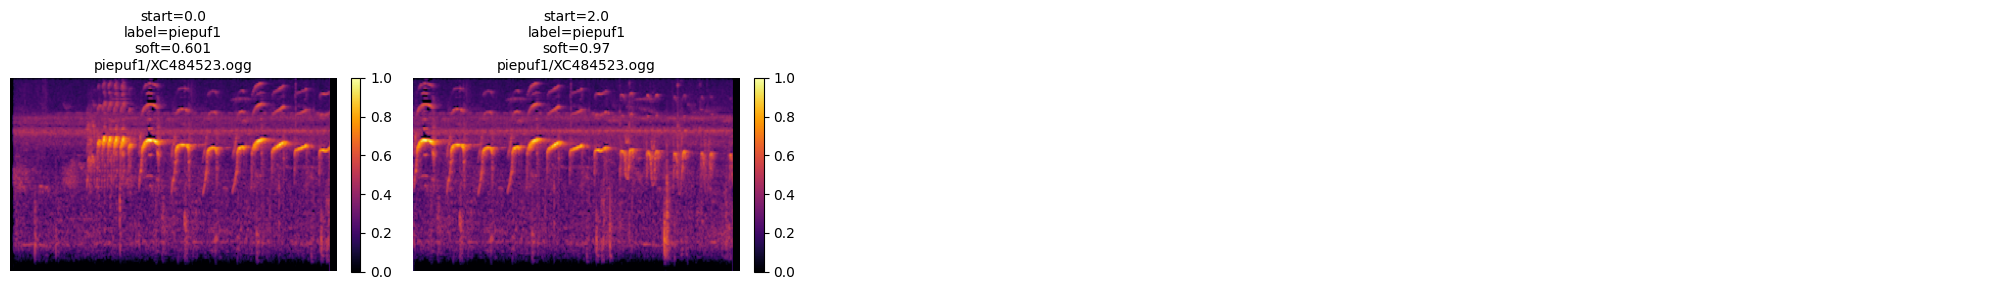

Audio associated with these birds with BirdNet predictions:


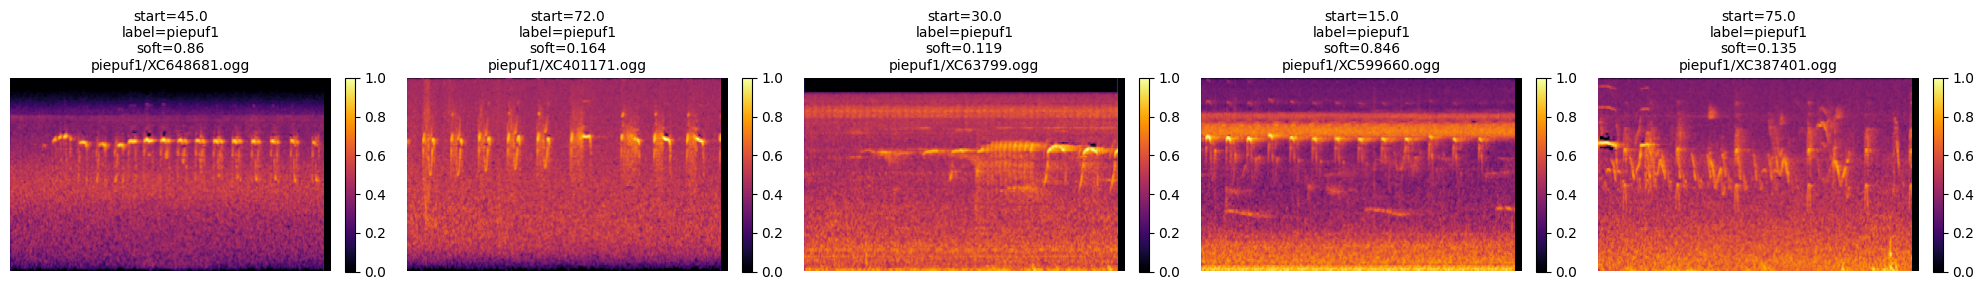

In [67]:
# Filter data to only those files with no BirdNet prediction (extra_files)
extra_files_data = google_data[google_data['filename'].isin(missing_val_files)]
extra_filenames = extra_files_data['filename'].unique()

# Pick a random file from files with no prediction
random_fname = random.choice(extra_filenames)
print(f"Audio with no BirdNet prediction for primary bird: {random_fname}")

# Sample up to 5 chunks from the chosen file with no prediction
no_pred_samples = extra_files_data[extra_files_data['filename'] == random_fname]
no_pred_sample_count = len(no_pred_samples)
no_pred_sampled = no_pred_samples.sample(min(5, no_pred_sample_count))

# Extract arrays for spectrogram extraction and plotting
fnames_no_pred = no_pred_sampled['filename'].values
start_times_no_pred = no_pred_sampled['start_time'].values
labels_no_pred = no_pred_sampled['primary_label'].values
soft_labels_no_pred = no_pred_sampled['confidence'].values

# Extract and plot spectrograms for files with no prediction
specs_no_pred = extract_spectrograms(fnames_no_pred, start_times_no_pred, audio_dir='train_audio')
plot_spectrograms_grid(specs_no_pred, fnames_no_pred, start_times_no_pred, labels_no_pred, soft_labels_no_pred, ncols=5)


# ---- Now handle files with BirdNet predictions for same birds ---- #

# Get unique primary bird labels from no prediction samples
birds_no_pred = list(set(labels_no_pred))

print('Audio associated with these birds with BirdNet predictions:')

for bird_label in birds_no_pred:
    # Filter BirdNet data for this bird label
    bird_samples = birdnet_data[birdnet_data['primary_label'] == bird_label]

    # Sample 5 chunks
    bird_samples_sampled = bird_samples.sample(min(5, len(bird_samples)))

    # Extract arrays for plotting
    fnames_bird = bird_samples_sampled['filename'].values
    start_times_bird = bird_samples_sampled['start_time'].values
    labels_bird = bird_samples_sampled['primary_label'].values
    soft_labels_bird = bird_samples_sampled['confidence'].values

    # Extract and plot spectrograms for BirdNet predictions matching that bird
    specs_bird = extract_spectrograms(fnames_bird, start_times_bird, audio_dir='train_audio')
    plot_spectrograms_grid(specs_bird, fnames_bird, start_times_bird, labels_bird, soft_labels_bird, ncols=5)